# A Bayesian Network to model the effects of an epidemic on a nation
### Student: Andrea Rossolini <br> Fundamentals of Artificial Intelligence and Knowledge Representation (mod. 3)

In the following notebook I developed a highly simplified Bayesian network to model the main consequence of a pandemic breakout in a nation, based on its population, density, GDP and so on.

The network is based on the famous SIR model, each letter denotes a state of individuals in a population: 
<ul>
    <li>S: number of susceptible</li>
    <li>I: number of infected</li>
    <li>R: number of removed</li>
</ul>

In this standard model is possible to extend the last state in <i>recovered</i> and <i>dead</i>, in this way in the network can be enrich with other concepts(???).

Such a model should be represented with a probabilistic reasoning model over time, so I decided to model the consequence of a pandemic after defined period of time (let say a month).




Note; say that I am thinking about COVID19

In this project is used the library <b>pgmpy</b>.<br>
By the fact there not exists data from which pgmpy can learn to build the network, I created some artificious values, while other are taken from differente sources (see at the bottom).
To simplify this work some continous variables had been devided in group.

In [105]:
import numpy as np
from scipy.stats import beta
from scipy.integrate import simps
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

Starting from the SIRD model explained above we can infer different features.
....
<br>
<ul>
    <li><b>Dens</b> = Density (pop./km^2):</li>
        <ul>
            <li>very low (< 30 e.g. Canada) 48/195</li>
            <li>low ([30,100] e.g. Brazil)  64/195</li>
            <li>Medium ([100,300] e.g. Italy) 55/195</li>
            <li>High ([300,600] e.g. Netherlands) 18/195</li>
            <li>very high (> 600 e.g. Bangladesh) 10/195</li>
        </ul>
    <li><b>Pop</b> = population
        <ul>
            <li>very low (< 1,000,000 e.g. Luxemburg) 39/195</li>
            <li>low ([1, 10] million e.g. Austria) 66/195</li>
            <li>medium ([10, 100] million e.g. Italy) 76/195</li>
            <li>High ([100m, 1b]  e.g. Brazil) 12/195</li>
            <li>Very High ([> 1b] e.g. India) 2/195</li>
        </ul>
    </li>
    <li><b>RP</b>  = Restriction Policies
        <ul>
            <li>None   (e.g. herd immunity)</li>
            <li>Light  (e.g. mask mandatory in public spaces, ban on gathering)</li>
            <li>Medium (e.g. Lockdown with exceptions for workers, travel restrictions)</li>
            <li>Severe (e.g. Lockdown including productive activities, country isolation)</li>
            <li>Extreme (e.g. Martial law)</li>
        </ul>
    </li>
    <li><b>GDP</b> = Gross Domesti product</li>
    <ul>
        <li>Low  (< 100b e.g. Luxemburg) 131/165</li>
        <li>Medium ([100b, 1t] e.g. Netherlands) 48/195</li>
        <li>High (> 1t e.g. Italy) 16/195</li>
    </ul>
    <li><b>S</b>  = Susceptible: percentage of population that can get sick (people cannot be susceptible for different reasons as immunity, life style, age ...)</li>
    <ul>
        <li>medium (at least 75% of population)</li>
        <li>high (at least 90% " ")</li>
    </ul>
    <li><b>Age</b> = Average Age</li>
    <ul>
        <li>young  (< 20) 40/230 </li>
        <li>avg    ([20, 40]) 140/230</li>
        <li>old    (> 40) 50/230</li>
    </ul>
    <li><b>I</b> = percentage of susceptibles Infected</li>
    <ul>
        <li> Low (< 0.3% e.g. Mongolia) </li>
        <li> Medium ([0.3,0.8%] e.g. Italy)</li>
        <li> High (>0.8% e.g. USA)</li>
    </ul>
    <li><b>HC</b> = Health Care system overall performances </li>
    <ul>
        <li>weak</li> <-- la probabilità è nel quadernino --!>
        <li>strong</li>
    </ul>
    <li><b>De</b> = Percentage of deaths </li>
    <ul>
        <li>Low  (< 4% of infected died)</li> 
        <li>High (> 4% of infected died)</li>
    </ul>
    <li><b>Re</b> = Percentage of recovered </li>
    <ul>
        <li>Low  (< 50% of infected recovered)</li>
        <li>High (> 50% of infected recovered)</li>
    </ul>
</ul>

It is possible to define the network strucure according to the features defined above. In the following cells it is explained how the network was conceived.

Using pgmpy we can simply wrote:

In [8]:
model = BayesianModel([('Dens', 'I'), ('Pop', 'S'), ('GDP', 'RP'), ('GDP', 'HC'),
                       ('RP', 'I'), ('S', 'I'), ('Age', 'De'), ('I', 'De'),
                       ('I', 'Re'), ('HC', 'De'), ('HC', 'Re')])

Now we must define the values for the conditional probability tables: <b> The numbers that we use are rather arbitrary guesses and we do not pretend them to be anyhow realistic.</b>
<br>For the node without parents (density, population, GDP, average age of each country) is simple: I used the data from  [1], [2], [3], [4].

In [9]:
# Defining CPD of nodes without parents
den_cpd = TabularCPD(variable='Dens',variable_card=5, 
                    values=[[0.24615384615384617], [0.3282051282051282], [0.28205128205128205], [0.09230769230769231], [0.05128205128205128]],
                    state_names={'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
pop_cpd = TabularCPD(variable='Pop',variable_card=5, 
                    values=[[0.2], [0.3384615384615385], [0.38974358974358975], [0.06153846153846154], [0.010256410256410256]],
                    state_names={'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
gdp_cpd = TabularCPD(variable='GDP',variable_card=3, 
                    values=[[0.6717948717948717], [0.24615384615384617], [0.08205128205128205]],
                    state_names={'GDP': ['Low', 'Medium', 'High']})
age_cpd = TabularCPD(variable='Age',variable_card=3, 
                    values=[[0.17391304347826086], [0.6086956521739131], [0.21739130434782608]],
                    state_names={'Age': ['Young', 'Avg', 'Old']})

model.add_cpds(den_cpd, pop_cpd, gdp_cpd, age_cpd)

In the following cell <i>Susceptible</i> and <i>Health Care system</i> and <i>Restriction Policies</i> are defined.
The first one is infuenced only by the population and it has no other relation with other net's features.


In [15]:
# Defining CPD of nodes with one parent
sus_cpd = TabularCPD(variable='S',variable_card=2, 
                     values=[[0.3, 0.35, 0.4, 0.45, 0.50], [0.7, 0.65, 0.6, 0.55, 0.5]],
                     evidence=['Pop'],
                     evidence_card=[5],
                     state_names={'S': ['Medium', 'High'],
                                 'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
HC_cpd = TabularCPD(variable='HC',variable_card=2, 
                     values=[[0.83, 0.42, 0.05], [0.17, 0.58, 0.95]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'HC': ['Weak', 'Strong'],
                                 'GDP': ['Low', 'Medium', 'High']})
RP_cpd = TabularCPD(variable='RP',variable_card=5,
                     values=[[0.29, 0.21, 0.12], 
                             [0.32, 0.37, 0.28], 
                             [0.19, 0.26, 0.39], 
                             [0.11, 0.13, 0.205], 
                             [0.09, 0.03, 0.005]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                 'GDP': ['Low', 'Medium', 'High']})

model.add_cpds(sus_cpd, HC_cpd, RP_cpd)

In [135]:
#CANCELLA
S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            res.append(tmp)
print(res)
print(len(res))
res.sort()
for n, elem in enumerate(res):
    if n == 0 or elem != res[n-1] :
        print("{0} - count {1}".format(elem, res.count(elem)))

[3.0, 2.5, 2.0, 1.5, 1.5, 3.5, 3.0, 2.5, 2.0, 1.5, 4.5, 4.0, 3.5, 3.0, 2.5, 5.5, 5.0, 4.5, 4.0, 3.5, 6.0, 5.5, 5.0, 4.5, 4.0, 3.25, 2.75, 2.25, 1.75, 1.5, 3.75, 3.25, 2.75, 2.25, 1.75, 4.75, 4.25, 3.75, 3.25, 2.75, 5.75, 5.25, 4.75, 4.25, 3.75, 6.25, 5.75, 5.25, 4.75, 4.25]
50
1.5 - count 4
1.75 - count 2
2.0 - count 2
2.25 - count 2
2.5 - count 3
2.75 - count 3
3.0 - count 3
3.25 - count 3
3.5 - count 3
3.75 - count 3
4.0 - count 3
4.25 - count 3
4.5 - count 3
4.75 - count 3
5.0 - count 2
5.25 - count 2
5.5 - count 2
5.75 - count 2
6.0 - count 1
6.25 - count 1


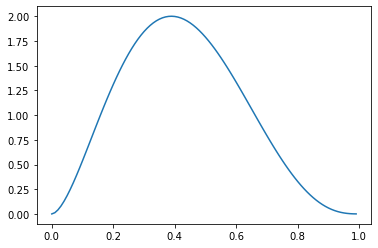

[0.00000000e+00 1.24485088e-02 4.07187791e-02 8.04831586e-02
 1.29411068e-01 1.85805245e-01 2.48305782e-01 3.15769534e-01
 3.87208203e-01 4.61751981e-01 5.38626167e-01 6.17135123e-01
 6.96650697e-01 7.76603527e-01 8.56476301e-01 9.35798395e-01
 1.01414150e+00 1.09111597e+00 1.16636781e+00 1.23957598e+00
 1.31045015e+00 1.37872869e+00 1.44417691e+00 1.50658540e+00
 1.56576867e+00 1.62156379e+00 1.67382918e+00 1.72244356e+00
 1.76730484e+00 1.80832923e+00 1.84545030e+00 1.87861814e+00
 1.90779857e+00 1.93297238e+00 1.95413460e+00 1.97129380e+00
 1.98447143e+00 1.99370122e+00 1.99902851e+00 2.00050967e+00
 1.99821158e+00 1.99221098e+00 1.98259400e+00 1.96945561e+00
 1.95289910e+00 1.93303556e+00 1.90998340e+00 1.88386787e+00
 1.85482059e+00 1.82297902e+00 1.78848609e+00 1.75148965e+00
 1.71214208e+00 1.67059981e+00 1.62702289e+00 1.58157455e+00
 1.53442072e+00 1.48572967e+00 1.43567152e+00 1.38441780e+00
 1.33214105e+00 1.27901438e+00 1.22521102e+00 1.17090389e+00
 1.11626518e+00 1.061465

In [122]:
#CANCELLA
from matplotlib import pyplot as plt 
from scipy.stats import beta

b = 3.75
a = 2.75

x = np.arange(0.0, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()
#x = np.random.beta(2.5,3.75,lim)
print(y)
print(len(y))

In [143]:
from scipy.stats import beta

S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5
max_ = 6

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            if tmp > max_ :
                tmp=max_
            res.append(tmp)

low, med, hig = [], [], []
x = np.arange(0.0, 1, 0.01)
b = 3.75
for a in res :
    y = beta.pdf(x,a,b)
    low.append(round(simps(y[:34])/100, 3))
    med.append(round(simps(y[34:67])/100, 3))
    hig.append(round(simps(y[67:])/100, 3))
    
print(low)
print('___'*20)
print(med)
print('___'*20)
print(hig)
print('**'*20)
print(max(low))
print(max(med))
print(max(hig))
print('**'*20)
print(min(low))
print(min(med))
print(min(hig))

[0.286, 0.383, 0.502, 0.635, 0.635, 0.208, 0.286, 0.383, 0.502, 0.635, 0.105, 0.149, 0.208, 0.286, 0.383, 0.05, 0.073, 0.105, 0.149, 0.208, 0.034, 0.05, 0.073, 0.105, 0.149, 0.244, 0.332, 0.44, 0.567, 0.635, 0.176, 0.244, 0.332, 0.44, 0.567, 0.088, 0.125, 0.176, 0.244, 0.332, 0.041, 0.06, 0.088, 0.125, 0.176, 0.034, 0.041, 0.06, 0.088, 0.125]
____________________________________________________________
[0.567, 0.505, 0.418, 0.311, 0.311, 0.605, 0.567, 0.505, 0.418, 0.311, 0.622, 0.622, 0.605, 0.567, 0.505, 0.584, 0.608, 0.622, 0.622, 0.605, 0.553, 0.584, 0.608, 0.622, 0.622, 0.589, 0.539, 0.464, 0.367, 0.311, 0.616, 0.589, 0.539, 0.464, 0.367, 0.616, 0.624, 0.616, 0.589, 0.539, 0.569, 0.597, 0.616, 0.624, 0.616, 0.553, 0.569, 0.597, 0.616, 0.624]
____________________________________________________________
[0.118, 0.084, 0.055, 0.032, 0.032, 0.156, 0.118, 0.084, 0.055, 0.032, 0.242, 0.198, 0.156, 0.118, 0.084, 0.336, 0.289, 0.242, 0.198, 0.156, 0.383, 0.336, 0.289, 0.242, 0.198, 0.136,

### Not Reliable References
<i>Wikipedia is not a reliable source, anyway, we just need indicative data.</i>


<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population#Lists_of_countries_by_population">[1] Wikipedia: List of countries by population</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density">[2] Wikipedia: List of countries by density</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)">[3] Wikipedia: List of countries by GDP (nominal)</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_median_age">[4] Wikipedia: List of countries by median age</a>

### References

<a name=\"first\"> [1] </a> [*U.S. Environmental Protection Agency - Greenhouse Gas Emissions*](https://www.epa.gov/ghgemissions/overview-greenhouse-gases)\n,
    \n,
    "<a name=\"second\">[2]</a> [*Didem Cinar, Gulgun Kayakutlu - Scenario analysis using Bayesian networks: A case study in energy sector*](https://www.sciencedirect.com/science/article/pii/S0950705110000110)\n",
    "\n",
    "<a name=\"third\">[3]</a> [*World Bank Open Data*](https://data.worldbank.org/indicator)"